#### 🎯 ***Bu proje 'Turkcell Geleceği Yazan Kadınlar Yapay Zeka' eğitimi kapsamında oluşturulmuştur.***
🖋️ **Betül Şakır, Elif Duymaz Yılmaz, Melike Ağırcan, İlke Dercan**

Çalışmada, Northwind veritabanı kullanılarak ürün satış performanslarını analiz etmek amacıyla bir **PostgreSQL** sorgusu oluşturulmuştur. Sorgu, sipariş detayları *(order_details)* tablosu ile ürünler *(products)* ve kategoriler *(categories)* tablolarını birleştirerek her bir ürün için toplam satış miktarını, toplam satış gelirini ve ortalama birim fiyatını hesaplamaktadır. Ürünler, kategori bilgileriyle birlikte gruplandırılmış ve toplam satış gelirine göre azalan sırayla sıralanmıştır.

İlk olarak, PostgreSQL veritabanına bağlantı kurabilmek ve veri işlemesi gerçekleştirebilmek için gerekli **Python** kütüphanelerini yüklememiz gerekmektedir. Bu adımda ***pandas, sqlalchemy, ve psycopg2*** kütüphaneleri kullanılmıştır.

>> Veritabanına bağlanabilmek için sqlalchemy kütüphanesi kullanılarak PostgreSQL bağlantı motoru oluşturulmuştur. Aşağıda, veritabanı bağlantısı için gerekli olan bilgiler doldurarak bağlantı gerçekleştirilmiştir:


### 1. Veri Oluşturma

In [1]:
from sqlalchemy import create_engine
import pandas as pd

PostgreSQL bağlantı bilgilerini oluşturma ve düzenleme : 

In [2]:
DB_USERNAME = "postgres"
DB_PASSWORD = "123456"
DB_HOST = "localhost" 
DB_PORT = "5432"
DB_NAME = "Gyk1Nortwind"

>> Bu satırda, PostgreSQL veritabanına **SQLAlchemy** aracılığıyla bağlanmak için bağlantı dizesi (```db_url```) oluşturulmuştur ve içine bir bağlantı dizesi (connection string) atanmıştır. Bağlantı dizesi, PostgreSQL veritabanına nasıl bağlanılacağını belirten bir formattadır.

⚠️ NOTE: **postgresql://: PostgreSQL veritabanına bağlanmak için kullanılan protokoldür.**

```{DB_USERNAME}:``` Veritabanına bağlanmak için kullanılan kullanıcı adı.

```{DB_PASSWORD}:``` Veritabanı kullanıcı şifresi.

```{DB_HOST}:``` Veritabanının barındığı sunucunun adresi (örneğin, "localhost" veya bir IP adresi).

```{DB_PORT}:``` Veritabanının dinlediği

```SQLAlchemy engine``` nesnesi, veritabanına bağlanmak ve sorgular çalıştırmak için bir arabirim sağlamaktadır.
```engine``` nesnesi, **Pandas** ile birlikte kullanılabilir ve doğrudan veritabanından veri çekilmesine imkan tanır.

In [3]:
db_url = f"postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(db_url)

📌 Aşağıdaki SQL sorgusu, ürünlerin satış performansını analiz etmek amacıyla hazırlanmıştır.  
Sorgu, `order_details` tablosundaki satış verilerini `products` ve `categories` tablolarıyla birleştirerek ürün ve kategori bilgilerini de içerecek şekilde zenginleştirilmiştir.

##### Sorgu çıktısı şu bilgileri içerir:
- **Ürün Kimliği** (`product_id`) ve **Ürün Adı** (`product_name`)
- **Kategori Bilgisi** (`category_id`, `category_name`)
- **Toplam Satış Miktarı** (`total_quantity`) — adet bazında
- **Toplam Satış Tutarı** (`total_sales`) — iskonto oranı dikkate alınarak hesaplanır
- **Ortalama Ürün Fiyatı** (`avg_price`)

##### Teknik Detaylar:
- `LEFT JOIN` ifadeleri ile ürün ve kategori bilgileri, satış verilerine bağlanmıştır.
- `GROUP BY` ifadesiyle her bir ürün bazında gruplama yapılmıştır.
- Sonuçlar `ORDER BY total_sales DESC` ile toplam satış tutarına göre azalan şekilde sıralanmıştır.

Bu yapı, özellikle en çok satan ürünleri tespit etmek ve kategori bazlı satış analizleri gerçekleştirmek için kullanılabilir.


In [ ]:
query = '''

SELECT
    p.product_id,
    p.product_name,
    p.category_id,
    c.category_name,
    SUM(od.quantity) AS total_quantity,
    SUM(od.unit_price * od.quantity * (1 - od.discount)) AS total_sales,
    AVG(od.unit_price) AS avg_price
FROM
    order_details od
LEFT JOIN
    products p ON od.product_id = p.product_id
LEFT JOIN
    categories c ON p.category_id = c.category_id
GROUP BY
    p.product_id, p.product_name, p.category_id, c.category_name
ORDER BY
    total_sales DESC;'''

df = pd.read_sql(query, engine)
df.to_csv("./data/data.csv", index=False)

### 2. Ön işlemler

#### 2.1 Eksik Veri Analizi

Aşağıdaki satır, oluşturulan veri kümesinde (DataFrame) sütun bazında kaç adet eksik değer (NaN) bulunduğunu analiz eder.

- `df.isna()` → Her hücre için eksik olup olmadığını kontrol eder (True/False)
- `.sum()` → Sütunlardaki True (yani NaN) değerleri toplar
- `print()` → Eksik veri sayısını ekrana yazdırır

Bu analiz, veri temizliği ve ön işleme adımları öncesinde eksik veri durumunu anlamak için kritik bir adımdır.


In [5]:
print(df.isna().sum())

product_id        0
product_name      0
category_id       0
category_name     0
total_quantity    0
total_sales       0
avg_price         0
dtype: int64


Verimizde NaN / Null değer olmadığı için işlemlere devam ediyoruz; ancak olması durumunda veri üzerindeki dağılıma bakılarak aşağıdaki işlemleri uygulayabilirdik.
- df.fillna(...) : Eksik verilerin uygun istatistiksel değerlerle doldurulması
- df.dropna(...) : Eksik verilerin bulunduğu satırların veri setinden çıkarılması


#### 2.2 Zaman ve Satış Tutarı Tabanlı Özellik Mühendisliği

Bu adımda, veri setine tarih ve satış bilgilerini detaylandırmak amacıyla yeni sütunlar eklenmektedir:

- `order_date` sütunu `datetime` formatına çevrilerek zaman bileşenlerine erişim sağlanır.
- `total_price`: Gerçek satış tutarı hesaplanır → (1 - indirim) * (birim fiyat * miktar)
- `year`, `month`, `day`: Sipariş tarihinden yıl, ay ve gün bilgileri çıkarılır.
- `yearquarter`: Yıl ve çeyrek bilgileri birleştirilerek dönemsel analizler için kullanılabilecek bir sütun oluşturulur  
  Örn: `2024 Q2`, `2025 Q1`

📌 **Bu işlemler; zaman serisi analizleri, dönemsel satış karşılaştırmaları ve gelir trendleri gibi analizlerde temel oluşturmuştur.**

In [6]:
df = pd.read_csv('./data/data.csv')
df

order_date customer_id         city  product_id  \
0     1996-07-04       VINET        Reims          11   
1     1996-07-04       VINET        Reims          42   
2     1996-07-04       VINET        Reims          72   
3     1996-07-05       TOMSP      Münster          14   
4     1996-07-05       TOMSP      Münster          51   
...          ...         ...          ...         ...   
2150  1998-05-06       RATTC  Albuquerque          64   
2151  1998-05-06       RATTC  Albuquerque          66   
2152  1998-05-06       RATTC  Albuquerque          73   
2153  1998-05-06       RATTC  Albuquerque          75   
2154  1998-05-06       RATTC  Albuquerque          77   

                         product_name  units_in_stock  unit_price  quantity  \
0                      Queso Cabrales              22       14.00        12   
1       Singaporean Hokkien Fried Mee              26        9.80        10   
2              Mozzarella di Giovanni              14       34.80         5   
3                                Tofu              35       18.60         9   
4               Manjimup Dried Apples              20       42.40        40   
...                               ...             ...         ...       ...   
2150        Wimmers gute Semmelknödel              22       33.25         2   
2151        Louisiana Hot Spiced Okra               4       17.00         1   
2152                       Röd Kaviar             101       15.00         2   
2153             Rhönbräu Klosterbier             125        7.75         4   
2154  Original Frankfurter grüne Soße              32       13.00         2   

      discount  category_id   category_name  
0         0.00            4  Dairy Products  
1         0.00            5  Grains/Cereals  
2         0.00            4  Dairy Products  
3         0.00            7         Produce  
4         0.00            7         Produce  
...        ...          ...             ...  
2150      0.03            5  Grains/Cereals  
2151      0.00            2      Condiments  
2152      0.01            8         Seafood  
2153      0.00            1       Beverages  
2154      0.00            2      Condiments  

[2155 rows x 11 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_date      2155 non-null   object 
 1   customer_id     2155 non-null   object 
 2   city            2155 non-null   object 
 3   product_id      2155 non-null   int64  
 4   product_name    2155 non-null   object 
 5   units_in_stock  2155 non-null   int64  
 6   unit_price      2155 non-null   float64
 7   quantity        2155 non-null   int64  
 8   discount        2155 non-null   float64
 9   category_id     2155 non-null   int64  
 10  category_name   2155 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 185.3+ KB


In [8]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['total_price'] = ((1-df['discount'])*(df['unit_price']*df['quantity']))
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['yearquarter'] = df['year'].astype(str) + ' Q' + df['order_date'].dt.quarter.astype(str)
df.head()

order_date customer_id     city  product_id                   product_name  \
0 1996-07-04       VINET    Reims          11                 Queso Cabrales   
1 1996-07-04       VINET    Reims          42  Singaporean Hokkien Fried Mee   
2 1996-07-04       VINET    Reims          72         Mozzarella di Giovanni   
3 1996-07-05       TOMSP  Münster          14                           Tofu   
4 1996-07-05       TOMSP  Münster          51          Manjimup Dried Apples   

   units_in_stock  unit_price  quantity  discount  category_id  \
0              22        14.0        12       0.0            4   
1              26         9.8        10       0.0            5   
2              14        34.8         5       0.0            4   
3              35        18.6         9       0.0            7   
4              20        42.4        40       0.0            7   

    category_name  total_price  year  month  day yearquarter  
0  Dairy Products        168.0  1996      7    4     1996 Q3  
1  Grains/Cereals         98.0  1996      7    4     1996 Q3  
2  Dairy Products        174.0  1996      7    4     1996 Q3  
3         Produce        167.4  1996      7    5     1996 Q3  
4         Produce       1696.0  1996      7    5     1996 Q3

#### 2.3 Aykırı Değer Tespiti (Outlier Detection) — IQR Yöntemi

Aşağıdaki fonksiyon, belirli bir sayısal sütun üzerinde **IQR (Interquartile Range)** yöntemini kullanarak aykırı değerleri tespit eder:

**Fonksiyon: `detect_outliers_iqr(data, column)`**

- **Q1 (1. Çeyrek)**: Verinin alt %25’lik kısmını temsil eder.
- **Q3 (3. Çeyrek)**: Verinin alt %75’lik kısmını temsil eder.
- **IQR (Çeyrekler Arası Aralık)**: `Q3 - Q1` ile hesaplanır.
- **Alt ve Üst Sınırlar**:
  - **Alt sınır** =  `Q1 - 1.5 * IQR`
  - **Üst sınır** = `Q3 + 1.5 * IQR`

Bu sınırların dışında kalan değerler **aykırı değer** (outlier) olarak kabul edilir ve filtrelenerek döndürülür.

📌 Bu yöntem, dağılımın dışında kalan uç değerleri belirlemek ve gerekirse bu değerleri analizden çıkarmak ya da ayrıca değerlendirmek için kullanılır.


In [9]:
print(df.describe())

                          order_date   product_id  units_in_stock  \
count                           2155  2155.000000     2155.000000   
mean   1997-08-05 06:12:11.693735424    40.793039       39.795824   
min              1996-07-04 00:00:00     1.000000        0.000000   
25%              1997-02-19 00:00:00    22.000000       17.000000   
50%              1997-09-04 00:00:00    41.000000       25.000000   
75%              1998-01-31 12:00:00    60.000000       57.000000   
max              1998-05-06 00:00:00    77.000000      125.000000   
std                              NaN    22.159019       36.055668   

        unit_price     quantity     discount  category_id   total_price  \
count  2155.000000  2155.000000  2155.000000  2155.000000   2155.000000   
mean     26.218520    23.812993     0.056167     4.135499    587.374960   
min       2.000000     1.000000     0.000000     1.000000      4.800000   
25%      12.000000    10.000000     0.000000     2.000000    147.000000   
50%

In [10]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

In [11]:
unit_price_outliers = detect_outliers_iqr(df, 'unit_price')
print(unit_price_outliers.head())

    order_date customer_id         city  product_id             product_name  \
11  1996-07-09       SUPRD    Charleroi          20   Sir Rodney's Marmalade   
55  1996-07-30       GROSR      Caracas          29  Thüringer Rostbratwurst   
62  1996-08-02       RATTC  Albuquerque          20   Sir Rodney's Marmalade   
112 1996-08-27       COMMI    Sao Paulo          29  Thüringer Rostbratwurst   
118 1996-08-28       TRADH    Sao Paulo          20   Sir Rodney's Marmalade   

     units_in_stock  unit_price  quantity  discount  category_id  \
11               40        64.8        40      0.05            3   
55                0        99.0        10      0.00            6   
62               40        64.8         6      0.00            3   
112               0        99.0        15      0.00            6   
118              40        64.8        20      0.00            3   

    category_name  total_price  year  month  day yearquarter  
11    Confections       2462.4  1996      7    

### 2.4 Aykırı Değerlerin Winsorize Edilmesi

Önceki adımda IQR yöntemiyle aykırı değerleri tespit ettik. Bu adımda ise, uç değerlerin etkisini azaltmak için **[Winsorizing](https://docs.scipy.org/doc/scipy-1.15.2/reference/generated/scipy.stats.mstats.winsorize.html)** yöntemini uyguluyoruz.

**Winsorize Nedir?**

Winsorizing, bir dağılımdaki en uç değerleri (örn. en yüksek ve en düşük %5 veya %10) belirli sınırlar içinde sabitleyerek daha istikrarlı analizler yapmayı sağlar.


In [12]:
from scipy.stats.mstats import winsorize

In [13]:
df['unit_price_winsorized_0.05'] = winsorize(df['unit_price'].values,  limits=[0.05, 0.05])
df.head()

order_date customer_id     city  product_id                   product_name  \
0 1996-07-04       VINET    Reims          11                 Queso Cabrales   
1 1996-07-04       VINET    Reims          42  Singaporean Hokkien Fried Mee   
2 1996-07-04       VINET    Reims          72         Mozzarella di Giovanni   
3 1996-07-05       TOMSP  Münster          14                           Tofu   
4 1996-07-05       TOMSP  Münster          51          Manjimup Dried Apples   

   units_in_stock  unit_price  quantity  discount  category_id  \
0              22        14.0        12       0.0            4   
1              26         9.8        10       0.0            5   
2              14        34.8         5       0.0            4   
3              35        18.6         9       0.0            7   
4              20        42.4        40       0.0            7   

    category_name  total_price  year  month  day yearquarter  \
0  Dairy Products        168.0  1996      7    4     1996 Q3   
1  Grains/Cereals         98.0  1996      7    4     1996 Q3   
2  Dairy Products        174.0  1996      7    4     1996 Q3   
3         Produce        167.4  1996      7    5     1996 Q3   
4         Produce       1696.0  1996      7    5     1996 Q3   

   unit_price_winsorized_0.05  
0                        14.0  
1                         9.8  
2                        34.8  
3                        18.6  
4                        42.4

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

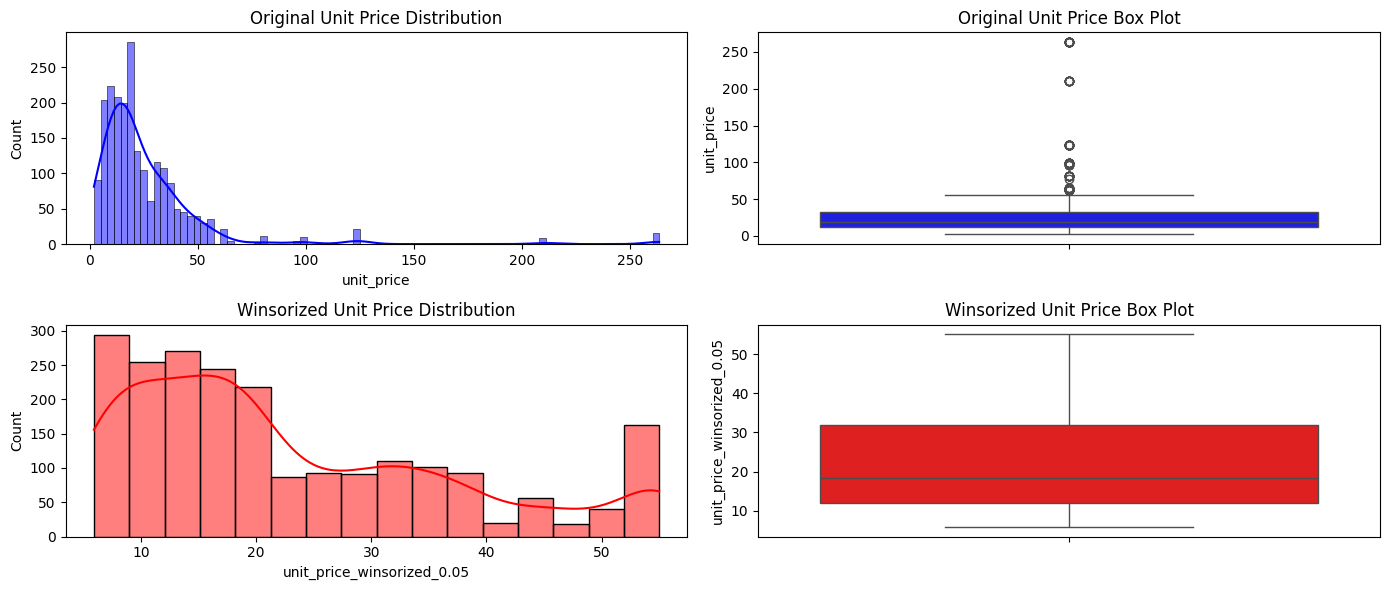

In [15]:
plt.figure(figsize=(14, 6))

# 1. Sütun: Unit Price Dağılımı
plt.subplot(2, 2, 1)
sns.histplot(df['unit_price'], kde=True, color='blue')
plt.title('Original Unit Price Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(y=df['unit_price'], color='blue')
plt.title('Original Unit Price Box Plot')

# 2. Sütun: Winsorized Unit Price Dağılımı
plt.subplot(2, 2, 3)
sns.histplot(df['unit_price_winsorized_0.05'], kde=True, color='red')
plt.title('Winsorized Unit Price Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(y=df['unit_price_winsorized_0.05'], color='red')
plt.title('Winsorized Unit Price Box Plot')

plt.tight_layout()
plt.show()

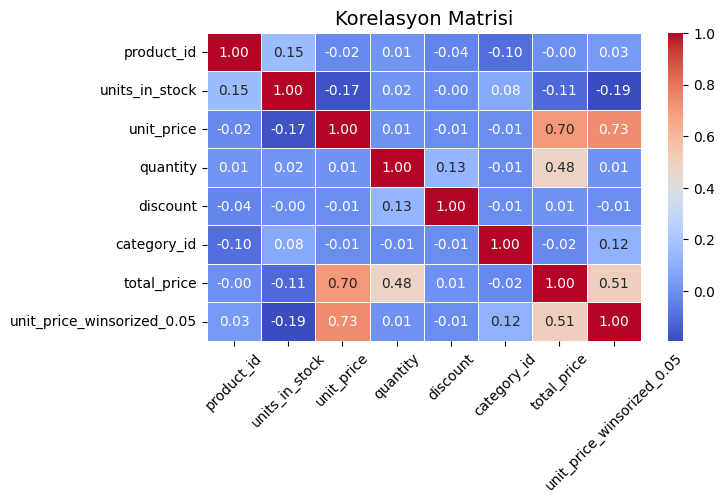

In [16]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_columns].corr()

# Correlation matrix
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Korelasyon Matrisi", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Amaç, belirli bir çeyrekte bir ürün için uygulanan indirim oranının satışları artırıp artırmayacağını tahmin etmektir.
Bu, bir sınıflandırma problemidir; çünkü hedef değişkenimiz (Y) ikili bir sınıftır:

- Eğer indirim yapılmışsa ve satış adedi artmışsa → 1 (indirim başarılı)

- Eğer indirim yapılmış ama satış artmamışsa → 0 (indirim başarısız)

In [17]:
# Label ekleme (discount_effective)
df['discount_effective'] = ((df['discount'] > 0) & 
                            (df['quantity'] > df.groupby(['product_id', 'yearquarter'])['quantity'].shift(1))
                           ).astype(int)

In [ ]:
df.to_csv('./data/processed_data.csv', index=False)

### 3. Model Seçimi / Test

Aşağıdaki kütüphaneler, veri analizi, modelleme ve görselleştirme işlemleri için kullanılacaktır:

- **pandas (`pd`)**: Veri işleme ve analiz için kullanılır.
- **numpy (`np`)**: Sayısal hesaplamalar için kullanılır.
- **matplotlib (`plt`) ve seaborn (`sns`)**: Görselleştirme ve grafikler oluşturmak için kullanılır.
- **scikit-learn**: Makine öğrenmesi algoritmaları ve metrikleri için kullanılır.
  - `train_test_split`: Veriyi eğitim ve test kümelerine ayırmak için kullanılır.
  - `GridSearchCV`: Hiperparametre optimizasyonda da görev alır.
  - `accuracy_score`, `precision_score`, `recall_score`, `f1_score`: Modelin doğruluğunu değerlendiren metrikledir.
  - `DecisionTreeClassifier`, `KNeighborsClassifier`, `LogisticRegression`: Farklı sınıflandırma algoritmalarıdır.
  - `MinMaxScaler`: Özelliklerin ölçeklendirilmesinde kullanılır.
- **imblearn**: Dengesiz veri kümelerini dengelemek için `SMOTE` (Synthetic Minority Over-sampling Technique) kullanılmıştır.

---

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [20]:
df = pd.read_csv('./data/processed_data.csv')
categorical_columns = ['product_name', 'category_name', 'yearquarter', 'city']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
# pd.get_dummies(): Kategorik değişkenleri sayısal verilere dönüştürmek için "one-hot encoding" uygulanır. 
# drop_first=True ile, ilk kategori düşürülerek çoklu doğrusal ilişkiler önlenir.

#### 3.1 Bağımsız ve Bağımlı Değişkenlerin Ayrılması

- **X**: **Bağımsız değişkenler (özellikler)** olarak adlandırılır. Bu, modelin tahmin yapmak için kullandığı tüm özellikleri içeren bir veri kümesidir. Burada, **`discount_effective`** dışındaki tüm sütunlar bu değişkene dahil edilir. Bu sütunlar, modelin öğrenmesi ve tahminler yapabilmesi için gerekli verileri sağlar.
  
- **y**: **Bağımlı değişken (etiket)** olarak bilinir ve modelin tahmin etmeye çalışacağı hedef değişkendir. Bu örnekte, **`discount_effective`** sütunu, modelin tahmin edeceği değer olarak belirlenmiştir. Yani, modelin çıktısı bu sütundaki değeri tahmin etmeye çalışacaktır.

In [22]:
X = df.drop(columns=['discount_effective', 'unit_price', 'order_date', 'customer_id', 'product_id', 'units_in_stock', 'category_id', 'year'])
y = df['discount_effective']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**SMOTE (Synthetic Minority Over-sampling Technique),** dengesiz veri kümelerinde azınlık sınıfının örneklerini artırmak için kullanılan bir tekniktir. Bu yöntem, azınlık sınıfına ait yeni örnekler oluşturarak, sınıflar arasındaki dengeyi sağlamaktadır.

- ```fit_resample()``` metodu, eğitim veri setini (X_train ve y_train) alır ve azınlık sınıfına ait yapay örnekler üretir. Bu, modelin her iki sınıfı daha eşit bir şekilde öğrenmesine olanak tanır.

- `random_state=42` parametresi, işlemin tekrarlanabilirliğini sağlar, yani aynı verilerle her seferinde aynı sonucu elde ederiz.

In [23]:
# SMOTE (data standardization)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

**Min-Max Scaling,** verinin değer aralığını [0, 1] arasına sıkıştırmak için kullanılan bir yöntemdir. Bu, özellikle mesafe tabanlı algoritmalar (örn. KNN) için önemlidir; çünkü bu algoritmalar veriler arasındaki mesafeleri kullanarak tahminler yapmaktadır.

- `fit_transform()` metodu, eğitim verisini ölçeklendirir ve dönüşümü uygular.

- `transform()` metodu, test verisini aynı ölçekleme parametreleriyle dönüştürür (eğitim verisinde öğrenilen parametrelerle).

>> Bu adım, modelin daha doğru ve hızlı bir şekilde öğrenmesini sağlamaktadır; çünkü her özellik aynı aralıkta yer alır.

In [24]:
# Min-Max Scaling (for KNN)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

📌 Bu adımlar, dengesiz veri setlerinde modelin doğruluğunu artırmak ve özelliklerin ölçeklendirilmesi ile modelin daha verimli bir şekilde çalışmasını sağlamak için kullanılmaktadır. SMOTE ile veri dengeleme ve Min-Max Scaling ile özellik ölçekleme, veriyi makine öğrenmesi algoritmalarına daha uygun hale getirmektedir.

#### 3.2 Farklı Modeller Oluşturma 

Makine öğrenmesi modellerini optimize etmek, doğru sınıflandırma ve tahmin sonuçları elde etmek için kritik bir adımdır. `Decision Tree`, `K-Nearest Neighbors (KNN)` ve `Logistic Regression` gibi yaygın algoritmalar, farklı veri yapıları ve problemler için çeşitli avantajlar sunmaktadır. Bu üç farklı yaklaşım, model performansını artırmak için hiperparametre optimizasyonu ve uygun değerlendirme metrikleriyle desteklendiğinde, daha sağlam ve güvenilir sonuçlar elde etmemizi sağlar.

- TRUE - POSITIVE (🟢) : Gerçek pozitif olanı doğru pozitif tahmin etme.
- TRUE - NEGATIVE (🔵) : Gerçek negatif olanı doğru negatif tahmin etme.
- FALSE - POSITIVE (🟠) : Gerçek negatif olanı yanlışlıkla pozitif tahmin etme (Type I error)
- FALSE - NEGATIVE (🔴) : Gerçek pozitif olanı yanlışlıkla negatif tahmin etme (Type II error)

---

- **Accuracy (Doğruluk):** Tüm sınıfladırmaların dengeli dağılım gösterdiği durumlarda başarı tespiti için kullanılabilir.
    > **Doğru Tahmin Sayısı / Toplam Tahmin Sayısı**
- **Precision (Kesinlik):** Modelin *pozitif tahminlerinden* kaç tanesinin gerçekten pozitif olduğunu ölçmek için kullanılmaktadır. Özellikle **yanlış pozitiflerin** maliyetli olduğu durumlarda önemlidir.
    > 🟢 / (🟢 + 🟠)
- **Recall (Duyarlılık):** Gerçek pozitif örneklerin ne kadarını doğru tahmin ettiğimizi göstermekte kullanılmaktadır. Kaçırılmaması gereken kritik durumlarda önceliğe sahiptir.
    > 🟢 / (🟢 + 🔴)
- **F1-Score:** Precision ve Recall’un harmonik ortalamasıdır. Bu iki metriği dengeleyerek, özellikle dengesiz veri setlerinde iyi bir değerlendirme sağlamaktadır.
    > **2 * (Precision * Recall) / (Precision + Recall)**
- **ROC-AUC:** Modelin pozitif ve negatif sınıfları ayırma başarısını ölçmede kullanılmaktadır. **Skor 1’e** yaklaştıkça; modelin ayırt etme gücü artmaktadır.
    > **1.0 = en iyi ayırım, 0.5 = düşük başarılı ayırım**

##### 3.2.1 Decision Tree

**Decision Tree** modeli, sınıflandırma problemlerinde kullanılan ve veriyi bir dizi karar kurallarıyla bölen bir algoritmadır. Bu modelin parametreleri üzerinde **GridSearchCV** ile en iyi kombinasyonu bulmak amacıyla denemeler yapılır.

`max_depth:` Ağacın derinliği, ağacın büyüklüğünü sınırlayan bir parametredir.

`min_samples_split:` Bir düğümün daha fazla bölünmesi için gereken minimum örnek sayısıdır.

`min_samples_leaf:` Yaprak düğümde bulunması gereken minimum örnek sayısıdır.

`GridSearchCV:` Belirli parametre kombinasyonları ile modelin doğruluğunu iyileştirmek için yapılan bir hiperparametre optimizasyon yöntemidir.

In [25]:
# for all results 
import numpy as np
results = []

In [26]:
dt_params = {"max_depth": [3, 5, 8, 10], "min_samples_split": [2, 5, 10, 20], "min_samples_leaf": [1, 5, 10]}
dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=10, n_jobs=-1, verbose=0)
dt_model.fit(X_train_balanced, y_train_balanced)
best_dt = dt_model.best_estimator_
y_dt_prediction = best_dt.predict(X_test)
y_dt_probability = best_dt.predict_proba(X_test)[:, 1]

results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_dt_prediction),
    "Precision": precision_score(y_test, y_dt_prediction),
    "Recall": recall_score(y_test, y_dt_prediction),
    "F1-Score": f1_score(y_test, y_dt_prediction),
    "ROC-AUC": roc_auc_score(y_test, y_dt_probability)
})

##### 3.2.2 K-Nearest Neighbors

**K-Nearest Neighbors (KNN),** bir örneğin sınıfını, ona en yakın K örneğin sınıflarına bakarak belirleyen bir sınıflandırma algoritmasıdır. Bu modelde `n_neighbors` parametresi, en yakın komşu sayısını belirtir.

- *GridSearchCV* yine burada farklı n_neighbors değerlerini deneyerek en iyi sonuçları elde etmek için kullanılır.

- KNN modelinin başarısı; _Accuracy, Precision, Recall, F1-Score ve ROC-AUC_ gibi metrikler ile değerlendirilir. Bu model için Min-Max Scaling uygulanır, çünkü KNN mesafe tabanlı bir algoritmadır ve verilerin uygun ölçeklenmesi önemlidir.

In [27]:
knn_params = {"n_neighbors": np.arange(1, 50)}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=10, n_jobs=-1, verbose=0)
knn_model.fit(X_train_scaled, y_train_balanced)
best_knn = knn_model.best_estimator_
y_knn_prediction = best_knn.predict(X_test_scaled)
y_knn_probability = best_knn.predict_proba(X_test_scaled)[:, 1]

results.append({
    "Model": "KNN",
    "Accuracy": accuracy_score(y_test, y_knn_prediction),
    "Precision": precision_score(y_test, y_knn_prediction),
    "Recall": recall_score(y_test, y_knn_prediction),
    "F1-Score": f1_score(y_test, y_knn_prediction),
    "ROC-AUC": roc_auc_score(y_test, y_knn_probability)
})

##### 3.2.3 Logistic Regression

**Logistic Regression (Lojistik Regresyon),** sınıflandırma problemleri için yaygın olarak kullanılan bir algoritmadır ve doğrusal bir modelin çıktısını sınıf olasılıklarına dönüştürür.

- `penalty:` Modelin ceza terimi türüdür (L1 veya L2 regularization).

- `C:` Regularization parametresidir. Daha küçük değerler daha fazla regularization (ceza) uygular.

- `solver:` Optimizasyon algoritmasıdır. Farklı optimizasyon yöntemlerini seçmek için kullanılır.

- `max_iter:` Optimizasyonun maksimum iterasyon sayısını belirler.

📌 **GridSearchCV** ile en iyi parametreler aranır ve modelin tahmin sonuçları çeşitli performans metrikleriyle değerlendirilir.

In [28]:
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 500]}
lr_model = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
lr_model.fit(X_train_balanced, y_train_balanced)
best_lr = lr_model.best_estimator_
y_lr_prediction = best_lr.predict(X_test)
y_lr_probability = best_lr.predict_proba(X_test)[:, 1]

results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_lr_prediction),
    "Precision": precision_score(y_test, y_lr_prediction),
    "Recall": recall_score(y_test, y_lr_prediction),
    "F1-Score": f1_score(y_test, y_lr_prediction),
    "ROC-AUC": roc_auc_score(y_test, y_lr_probability)
})

/Users/elifdy/VScode/myPython.v1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/elifdy/VScode/myPython.v1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/elifdy/VScode/myPython.v1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/elifdy/VScode/myPython.v1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/elifdy/VScode/myPython.v1/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/elifdy/V

##### 3.3 Sonuç Tabloları  
`results_df` modellerin performans metriklerini içeren bir DataFrame'dir. Bu DataFrame; modelin Accuracy, Precision, Recall, F1-Score, ve ROC-AUC gibi başarı ölçütleri ile karşılaştırılmaların saptanmasında kullanılacaktır.

In [29]:
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0        Decision Tree  0.825986   0.462264  0.731343  0.566474  0.852571
1                  KNN  0.839907   0.454545  0.149254  0.224719  0.690196
2  Logistic Regression  0.839907   0.477273  0.313433  0.378378  0.819706


🍄 **ROC Eğrisi:** Modelin farklı eşik değerlerinde elde edilen sınıflandırma başarısını görselleştirmek için kullanılan performans ölçüm grafiğidir. Eğri altındaki alan (AUC) ne kadar yüksekse, model o kadar iyi performans gösteriyor kabul edilmektedir.

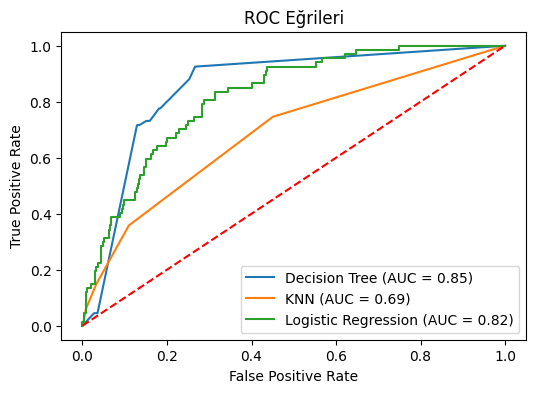

In [30]:
# --- ROC  ---
plt.figure(figsize=(6, 4))
for model_name, y_probability in zip(
    ["Decision Tree", "KNN", "Logistic Regression"],
    [y_dt_probability, y_knn_probability, y_lr_probability]
):
    fpr, tpr, _ = roc_curve(y_test, y_probability)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_probability):.2f})")

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.show()

🍄 **Confusion Matrix:** Modelin doğru ve yanlış tahminlerini belirlemek için kullanılmaktadır. 

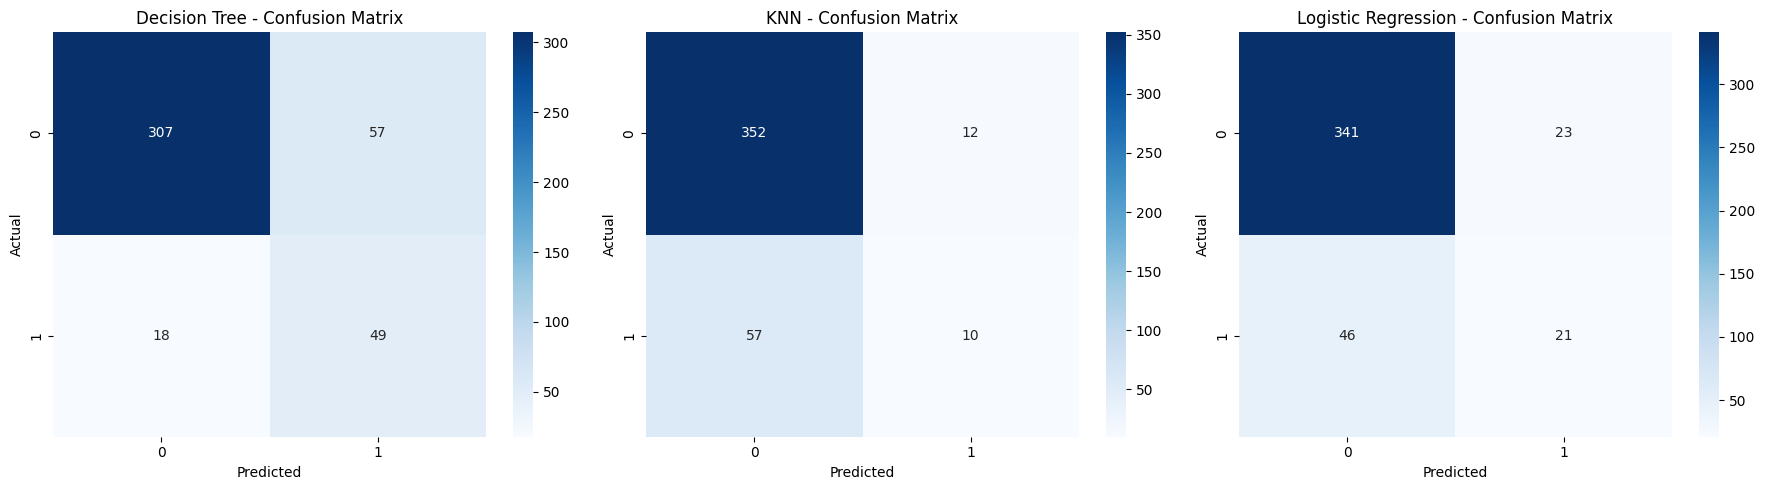

In [31]:
# --- CONFUSION MATRIX GRAPHS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model_name, y_prediction in zip(
    axes,
    ["Decision Tree", "KNN", "Logistic Regression"],
    [y_dt_prediction, y_knn_prediction, y_lr_prediction]
):
    cm = confusion_matrix(y_test, y_prediction)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"], ax=ax)
    ax.set_title(f"{model_name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

#### 4. API Oluşturma

Yukarıda yapılan ön işlemlerde **'decision tree' (karar ağacı)** modelinin sonuçları diğer modellere göre daha yüksek başarı göstermiştir, bu nedenle aşağıdaki kod bloğu, ürün satış verilerine dayalı olarak bir indirimin etkili olup olmadığını tahmin eden bir makine öğrenmesi modelini eğitmek, kaydetmek ve bir RESTful API aracılığıyla kullanıma sunmak amacıyla oluşturulmuştur. Model, **karar ağacı** algoritmasıyla eğitilmekte ve veri dengesizliği **SMOTE** yöntemiyle giderilmektedir. Eğitilen model daha sonra **FastAPI** ile servise dönüştürülerek dışarıdan gelen kullanıcı verilerine göre anlık tahminler yapılmasına olanak tanımaktadır. Böylece, farklı uygulamalar bu API üzerinden modele erişerek dinamik tahminlerde bulunabilecektir.

In [32]:
import pandas as pd
import numpy as np

import joblib
from fastapi import FastAPI
from pydantic import BaseModel

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import random

In [33]:
df = pd.read_csv('./data/processed_data.csv')

Öncelikle modelin anlayacağı uygunlukta *product_name, category_name, yearquarter* ve *city* değişkenleri sayısal formatlara dönüştürülmüştür. Burada, `pd.get_dummies()` fonksiyonu kullanılarak **one-hot encoding** uygulanır.

- `drop_first=True` parametresi ile dummy variable trap (çoklu doğrusal bağımlılık) engellenmektedir. Ardında, doğrudan sonucu etkilemeyen veya tanımlayıcı olan değişkenler veri setinden çıkarılmıştır. 
- `discount_effective` değişkeni hedef değişken olarak `y` değişkenine atanmıştır.

In [34]:
categorical_columns = ['product_name', 'category_name', 'yearquarter','city'] 
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

X = df.drop(columns=['discount_effective', 'order_date', 'customer_id', 'product_id', 'category_id'])
y = df['discount_effective']

SMOTE, dengesiz sınıf dağılımını dengelemek için kullanılan bir over-sampling yöntemidir. Sınıflardan biri diğerine göre çok daha az gözleme sahip olduğu durumlarda, model bu sınıfı öğrenmekte zorlanabilir. SMOTE, azınlık sınıf için yeni sentetik örnekler oluşturarak veri setini dengeler.
Bu adım sonucunda dengelenmiş giriş ve hedef değişkenleri (X_balanced, y_balanced) elde edilmiştir ve model, X_balanced ve y_balanced verileri ile eğitilmiştir.

`max_depth=4`, ağacın derinliğini sınırlayarak aşırı öğrenme (overfitting) riski azaltılmıştır ve modelin genellenebilirliği artırılmıştır.

In [35]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_balanced, y_balanced)

DecisionTreeClassifier(max_depth=4, random_state=42)

Model `.pkl` dosyası olarak saklanır. Böylece tekrar eğitmeye gerek kalmadan doğrudan kullanılabilir.

In [36]:
joblib.dump(model, './results/sales_model.pkl')
joblib.dump(X.columns.tolist(), './results/model_features.pkl')

['./results/model_features.pkl']

In [37]:
app = FastAPI(title="Sales Discount Effect Predictor", description="Predicts if discount increased sales.")

model = joblib.load('./results/sales_model.pkl')
model_columns = joblib.load('./results/model_features.pkl')

In [38]:
class SaleInput(BaseModel):
    order_date: str
    customer_id: str
    city: str
    product_id: int
    product_name: str
    units_in_stock: int
    unit_price: float
    quantity: int
    discount: float
    category_id: int
    category_name: str
    winsorize_unit_price: float
    total_price: float
    year: int
    yearquarter: str

In [39]:
def preprocess_input(sale: SaleInput):
    df_input = pd.DataFrame([sale.dict()])

    categorical_columns = ['product_name', 'category_name', 'yearquarter', 'city']
    df_input = pd.get_dummies(df_input, columns=categorical_columns, drop_first=True)

    for col in model_columns:
        if col not in df_input.columns:
            df_input[col] = 0

    return df_input[model_columns]


#### 4.2 Tahmin Servisi (POST Endpoint)

Burada '/predict' endpoint’i ile gelen kullanıcı verisi alınabilir. Model `.pkl` dosyasından yüklenerek veri üzerinde tahmin yapılır durumdadır.
>> **Tahmin sonucu (indirim etkisi var mı yok mu) kullanıcıya yanıt olarak döndürülecektir.**

In [40]:

@app.post("/predict")
def predict(sale: SaleInput):
    input_df = preprocess_input(sale)
    prediction = model.predict(input_df)[0]
    result = "Sales are booming! Time to scale up operations 🚀" if prediction == 1 else "Sales are sluggish. Let's strategize for improvement 📉"


    return {
        "prediction": result,
        "input_summary": sale.dict()
    }

>> Örnek kullanım : 

In [1]:
# terminalde -> uvicorn step4_api_main:app --reload çalıştırıyoruz.

In [41]:
import requests

url = "http://127.0.0.1:8000/predict"

data = {
  "order_date": "2004-07-08",
  "customer_id": "VICTE",
  "city": "Lyon",
  "product_id": 65,
  "product_name": "Louisiana Fiery Hot Pepper Sauce",
  "units_in_stock": 76,
  "unit_price": 16.8,
  "quantity": 20,
  "discount": 0.4,
  "category_id": 2,
  "category_name": "Condiments",
  "winsorize_unit_price": 16.8,
  "total_price": 336.0,
  "year": 2004,
  "yearquarter": "2004 Q3"

}

response = requests.post(url, json=data)

print("Status Code:", response.status_code)
print("Prediction Result:", response.json())


Status Code: 200
Prediction Result: {'prediction': 'Sales are booming! Time to scale up operations 🚀', 'input_summary': {'order_date': '2004-07-08', 'customer_id': 'VICTE', 'city': 'Lyon', 'product_id': 65, 'product_name': 'Louisiana Fiery Hot Pepper Sauce', 'units_in_stock': 76, 'unit_price': 16.8, 'quantity': 20, 'discount': 0.4, 'category_id': 2, 'category_name': 'Condiments', 'winsorize_unit_price': 16.8, 'total_price': 336.0, 'year': 2004, 'yearquarter': '2004 Q3'}}
